**Importing necessary libraries**

In [1]:
import tensorflow.keras as K
import keras
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import os;
import datetime
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

**Importing and analyzing breast cancer images**

In [2]:
# load images of shape (5547, 50, 50, 3)
x_images = np.load('/content/X.npy')

# load labels of shape (5547,1); (0 = no cancer, 1 = cancer)
y_images = np.load('/content/Y.npy')

# shuffle data
perm_array = np.arange(len(x_images))
np.random.shuffle(perm_array)
x_images = x_images[perm_array]
y_images = y_images[perm_array]

print('x_images.shape =', x_images.shape)
print('x_images.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images.min(),
                        x_images.mean(), x_images.std(), x_images.max()))
print('')
print('y_images.shape =', y_images.shape)
print('y_images.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(y_images.min(),
                        y_images.mean(), y_images.std(), y_images.max()))

x_images.shape = (5547, 50, 50, 3)
x_images.min/mean/std/max = 2.00/185.03/47.25/255.00

y_images.shape = (5547,)
y_images.min/mean/std/max = 0.00/0.50/0.50/1.00


**Printing 30 images along with their IDC value**

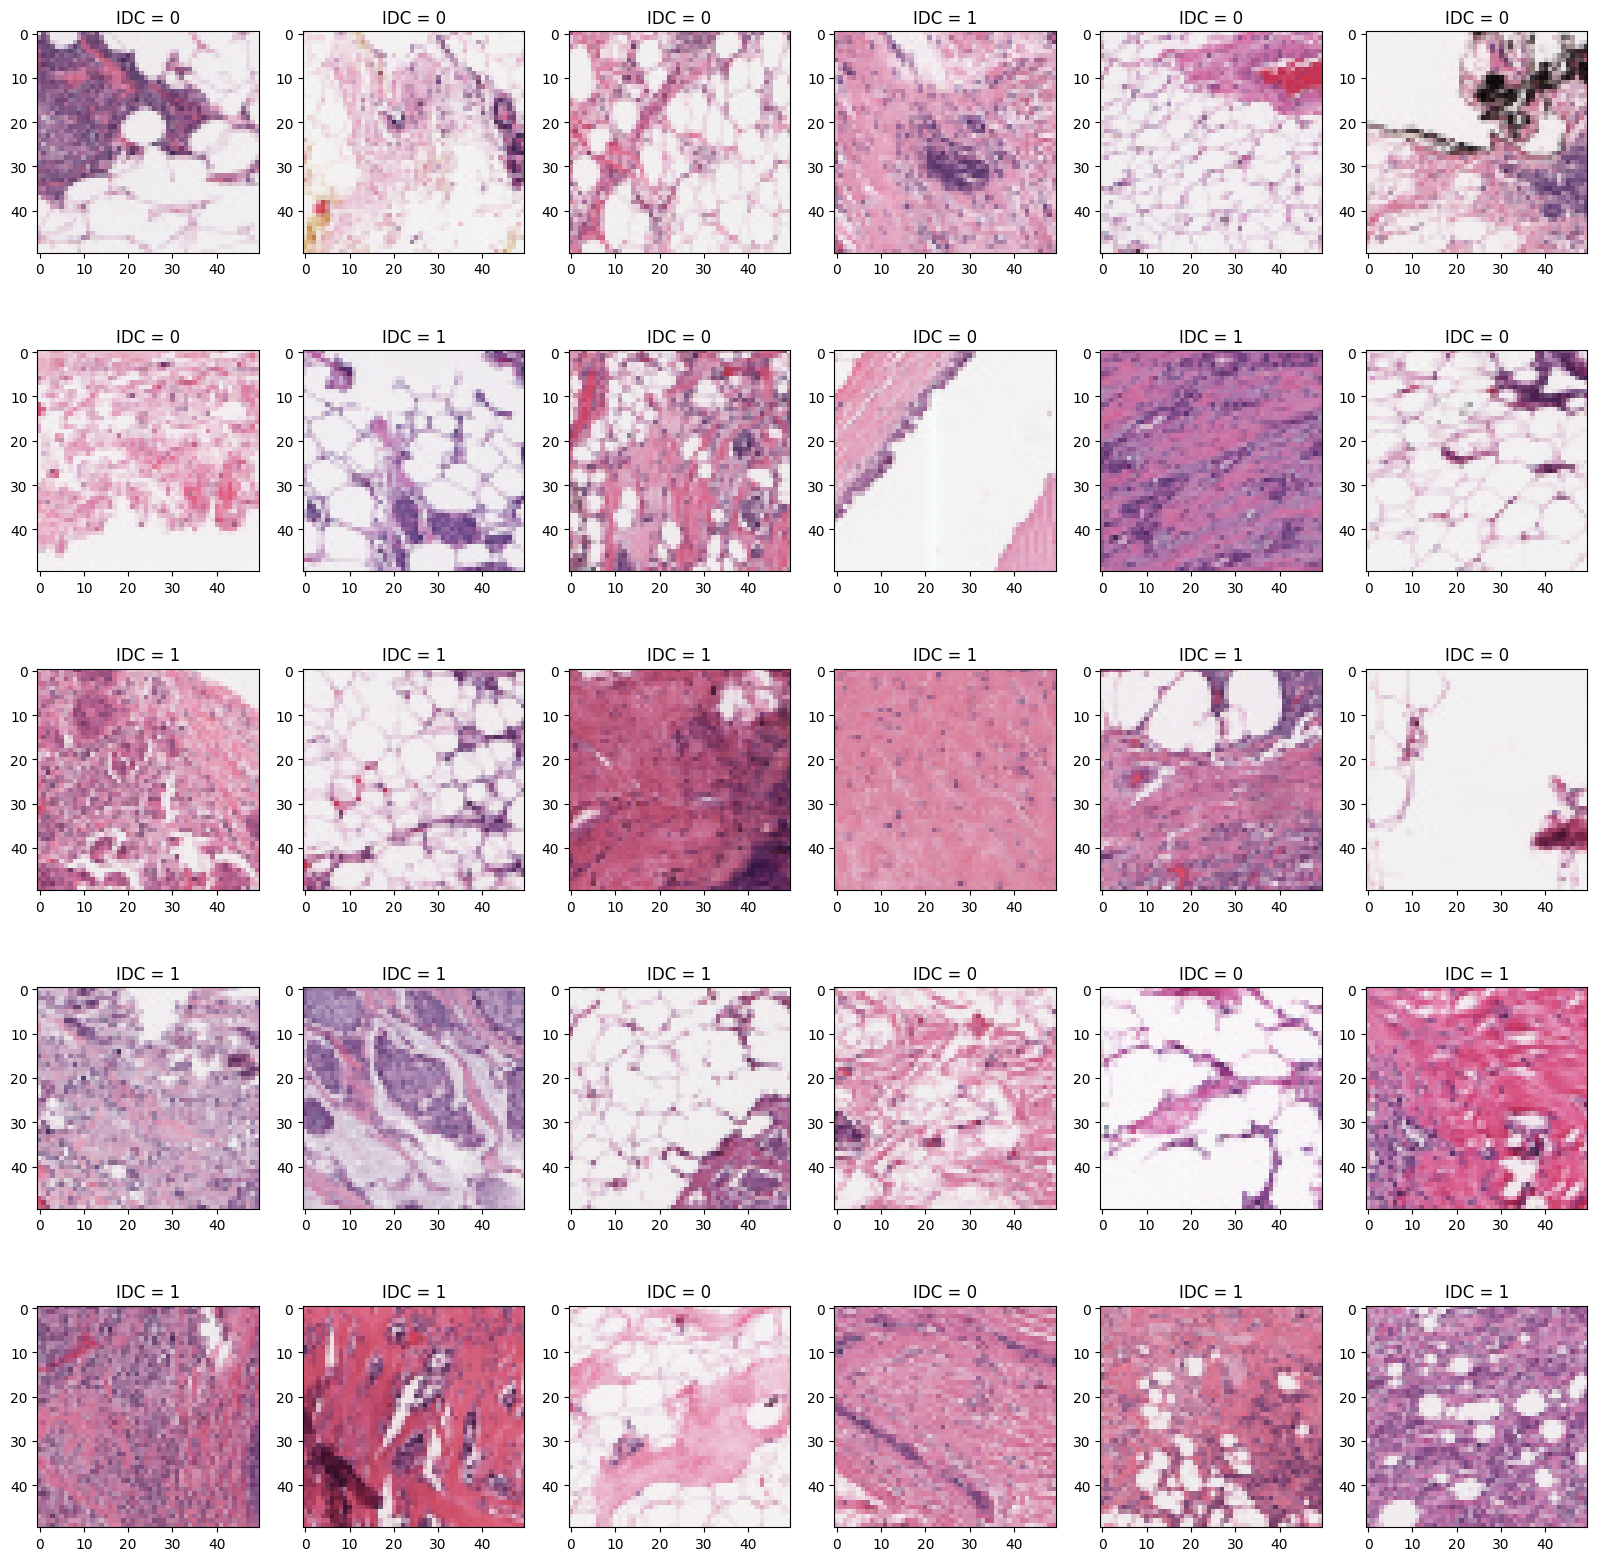

In [3]:
imgs_0 = x_images[y_images == 0] # 0 = no cancer
imgs_1 = x_images[y_images == 1] # 1 = cancer

plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.title('IDC = %d'%y_images[i])
    plt.imshow(x_images[i])

**Plotting histograms of RGB values for image with breast cancer and without breast cancer**

red channel: min/mean/std/max = 4.00/205.79/36.29/255.00
green channel: min/mean/std/max = 2.00/161.87/53.94/255.00
blue channel: min/mean/std/max = 5.00/187.44/38.69/255.00


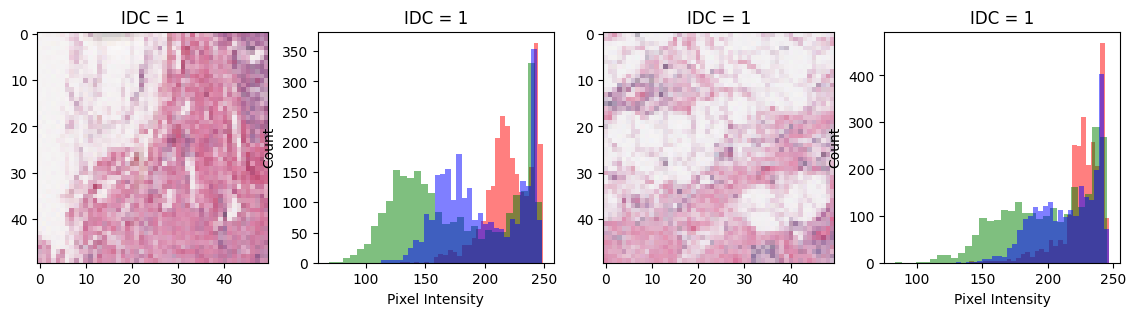

In [4]:
plt.figure(figsize=(14,3))

for i in range(2):
    n_img = np.random.randint(len(x_images))
    plt.subplot(1,4,1+2*i)
    plt.title('IDC = %d'%y_images[n_img])
    plt.imshow(x_images[n_img])
    plt.subplot(1,4,2+2*i)
    plt.title('IDC = %d'%y_images[n_img])
    plt.ylabel('Count')
    plt.xlabel('Pixel Intensity')
    plt.hist(x_images[n_img,:,:,0].flatten(), bins=30, lw = 0,color='r', alpha=0.5);
    plt.hist(x_images[n_img,:,:,1].flatten(), bins=30, lw = 0, color='g', alpha=0.5);
    plt.hist(x_images[n_img,:,:,2].flatten(), bins=30, lw = 0, color='b', alpha=0.5);
print('red channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images[:,:,:,0].min(),
    x_images[:,:,:,0].mean(), x_images[:,:,:,0].std(), x_images[:,:,:,0].max()))
print('green channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images[:,:,:,1].min(),
    x_images[:,:,:,1].mean(), x_images[:,:,:,1].std(), x_images[:,:,:,1].max()))
print('blue channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images[:,:,:,2].min(),
    x_images[:,:,:,2].mean(), x_images[:,:,:,2].std(), x_images[:,:,:,2].max()))


In [5]:
x_images.shape

(5547, 50, 50, 3)

In [6]:
y_images.shape

(5547,)

**Preprocessing data**

Preprocessing the data using ResNet 50 pretrained model from Keras





In [7]:
def preprocess(X,Y):
    # X is a numpy array of shape (n,50,50,3) where n is number of images, 3 represents RGB colours
    # Y is a numpy array of shape (n,1) where n is number of images
    X_p = K.applications.resnet50.preprocess_input(X)
    Y_p = K.utils.to_categorical(Y,2)
    #a,b,c,d = X_p.shape
    #X_p= np.reshape(X_p,(a,d))
    return X_p, Y_p

Splitting data into train and test splits in 80:20 ratio and preprocessing them

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x_images, y_images, test_size=0.2, random_state=42)
X_train, y_train = preprocess(X_train, y_train)
X_test, y_test = preprocess(X_test, y_test)

**Building and training the model**


Importing the pretrained ResNet50 model to use pretrained weights

In [9]:
input_t = K.Input(shape = (224,224,3))
res_model = K.applications.ResNet50(include_top = False, weights = "imagenet", input_tensor = input_t)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


We make all layers except the last one untrainable so as to fix them and reduce computation cost

In [10]:
for layer in res_model.layers[:143]:
        layer.trainable = False


Adding ResNet-50 model to Keras Sequential Layers and adding more Layers

In [11]:
to_res = (224, 224)
model = K.models.Sequential()
model.add(K.layers.Lambda(lambda image: tf.image.resize(image, to_res)))
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(256, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(128, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(64, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(2, activation='softmax'))

**Training the model and storing the model with best val_accuracy**

In [12]:
check_point = K.callbacks.ModelCheckpoint(filepath="XAI.healthcare.keras",
                                              monitor="val_acc",
                                              mode="max",
                                              save_best_only=True,
                                              )
model.compile(
    loss='categorical_crossentropy',
    optimizer=K.optimizers.RMSprop(learning_rate=2e-3),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=10,
    verbose=1,
    validation_data=(X_test, y_test)
)

model.summary()

Epoch 1/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 1403s 5s/step - accuracy: 0.5614 - loss: 0.8492 - val_accuracy: 0.6829 - val_loss: 1.8089
Epoch 2/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 1416s 5s/step - accuracy: 0.7365 - loss: 0.5494 - val_accuracy: 0.7856 - val_loss: 0.7196
Epoch 3/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 1387s 5s/step - accuracy: 0.7778 - loss: 0.4887 - val_accuracy: 0.7811 - val_loss: 0.7351
Epoch 4/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 1438s 5s/step - accuracy: 0.8145 - loss: 0.4321 - val_accuracy: 0.7919 - val_loss: 0.4143
Epoch 5/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 1414s 5s/step - accuracy: 0.8410 - loss: 0.3838 - val_accuracy: 0.7387 - val_loss: 0.6224
Epoch 6/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 1421s 5s/step - accuracy: 0.8643 - loss: 0.3227 - val_accuracy: 0.7766 - val_loss: 0.6719
Epoch 7/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 1412s 5s/step - accuracy: 0.8882 - loss: 0.2816 - val_accuracy: 0.7793 - val_loss: 0.5233
Epoch 8/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 1416s 5s/step - accuracy: 0.9108 - loss: 0.2482 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100352)         │       401,408 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,631,814 (345.73 MB)

 Trainable params: 40,909,250 (156.06 MB)

 Non-trainable params: 8,813,312 (33.62 MB)

 Optimizer params: 40,909,252 (156.06 MB)

**Showing the progression of val_accuracy, val_loss, accuracy and loss with respect to each epoch**

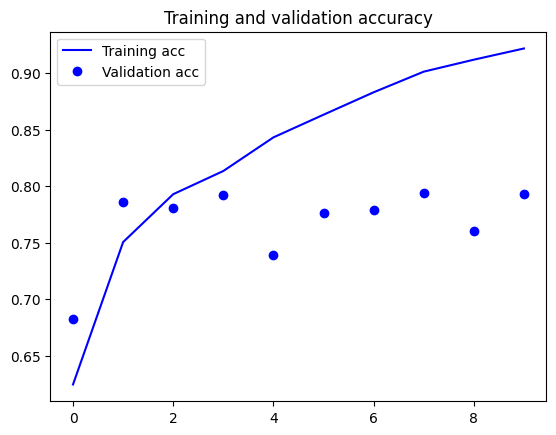

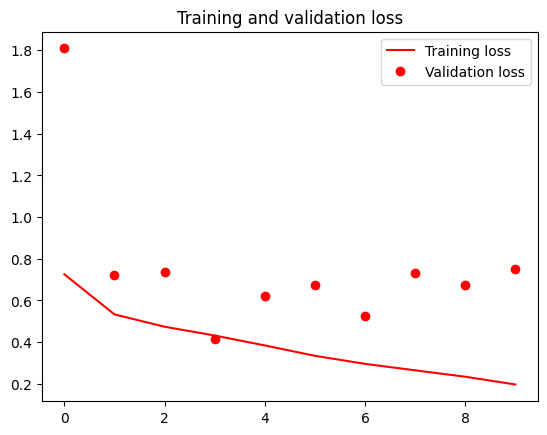

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
history.history

{'accuracy': [0.6245210766792297,
  0.750507116317749,
  0.7928780913352966,
  0.8133874535560608,
  0.843137264251709,
  0.8631958365440369,
  0.8830291032791138,
  0.9012846350669861,
  0.9118773937225342,
  0.9217939972877502],
 'loss': [0.7249232530593872,
  0.5326388478279114,
  0.47348693013191223,
  0.4312652349472046,
  0.38369253277778625,
  0.33397769927978516,
  0.2952595353126526,
  0.2642642855644226,
  0.2335880994796753,
  0.19630977511405945],
 'val_accuracy': [0.6828829050064087,
  0.7855855822563171,
  0.7810810804367065,
  0.791891872882843,
  0.7387387156486511,
  0.776576578617096,
  0.7792792916297913,
  0.7936937212944031,
  0.7603603601455688,
  0.792792797088623],
 'val_loss': [1.8089091777801514,
  0.7196446061134338,
  0.7350706458091736,
  0.41427093744277954,
  0.6224491596221924,
  0.6719061136245728,
  0.5232970118522644,
  0.7314292192459106,
  0.6744651198387146,
  0.7526571750640869]}

**Displaying the final accuracies**

In [15]:
print("Validation Accuracy: ",max(history.history['val_accuracy']))
print("Training Accuracy: ",max(history.history['accuracy']))

Validation Accuracy:  0.7936937212944031
Training Accuracy:  0.9217939972877502


**Making prediction on the test dataset**

In [16]:
y_pred = model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 184s 5s/step


**Making a list containing the final predictions for X_test**

In [ ]:

y_classes = [np.argmax(y, axis=None, out=None) for y in y_pred]


**Displaying images with and without cancer **

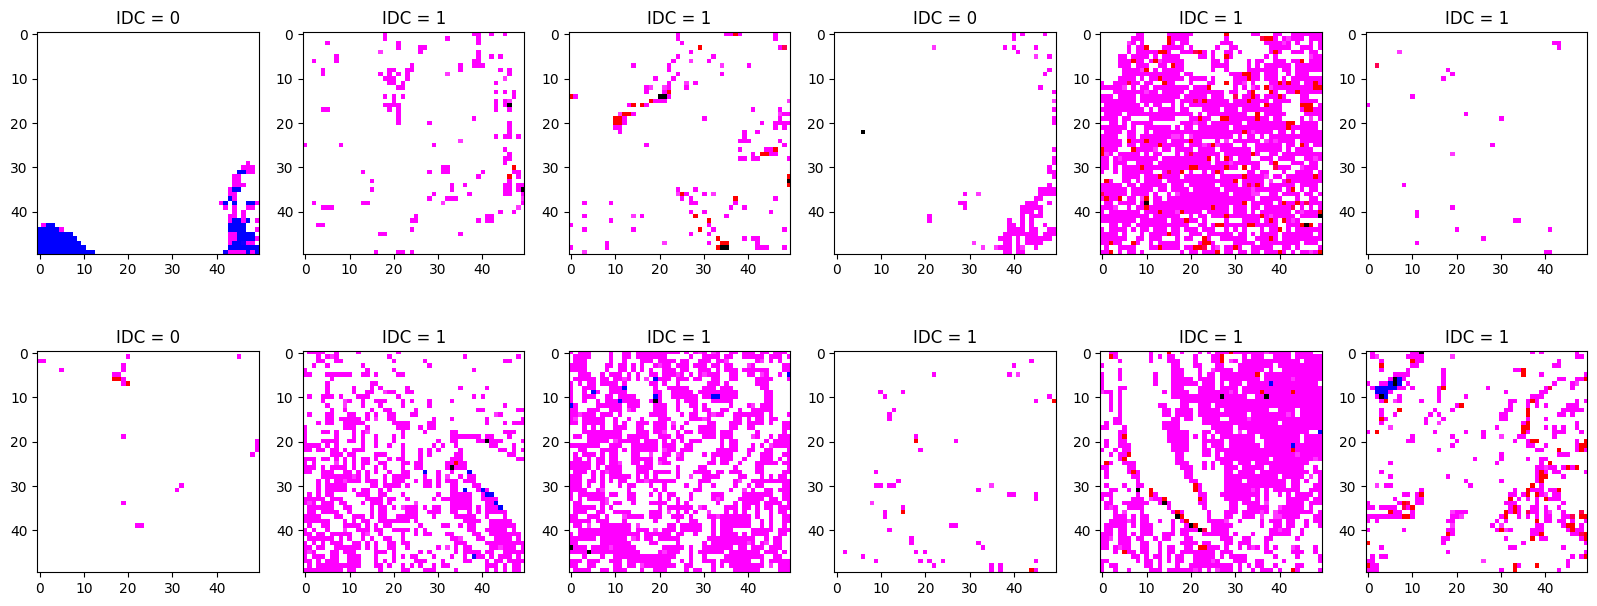

In [27]:
imgs_0 = X_test[y_classes == 0] # 0 = no cancer
imgs_1 = X_test[y_classes == 1] # 1 = cancer

plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(5,6,i+1)
    plt.title('IDC = %d'%y_classes[i])
    plt.imshow(X_test[i])

**Post-hoc explanation**

Importing and created LIME image explainer

In [32]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(X_test[100].astype('double'), model.predict,
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

Visualizing the LIME explaination using scikit-learn's segmenation

In [22]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b3ed7239733a73507051407587fd443e32adf87183304b74946a2b68ed8b1aef
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [26]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

# Assuming you have `image` and a prediction function `predict_fn`
image = X_test[100].astype('double')
predict_fn = model.predict

explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

(np.float64(-0.5), np.float64(49.5), np.float64(49.5), np.float64(-0.5))

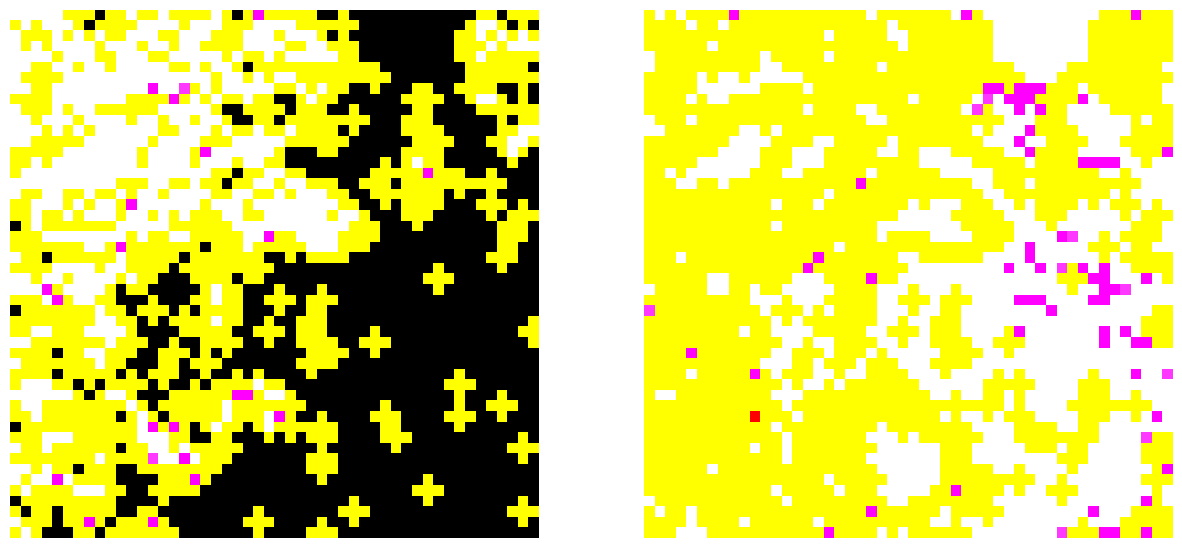

In [33]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

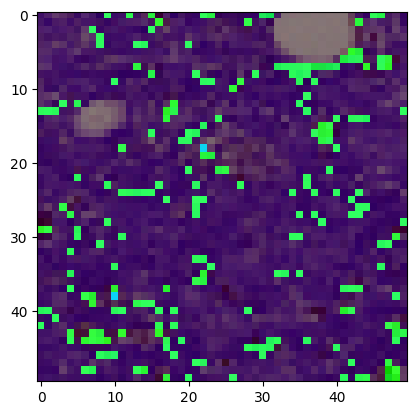

In [34]:
plt.imshow(X_test[100].astype('uint8'))

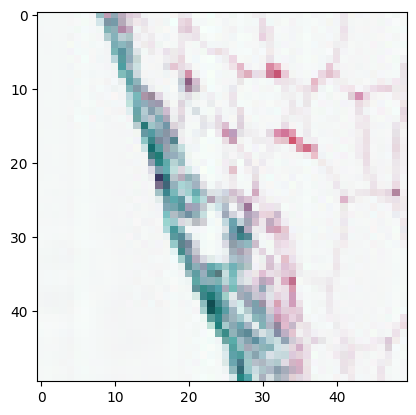

In [35]:
plt.imshow(x_images[100].astype('uint8'))

Visualizing the LIME explanation using heatmap

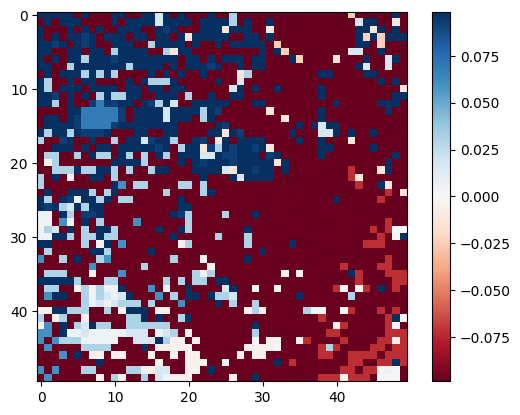

In [36]:
ind =  explanation.top_labels[0]
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()